<a href="https://colab.research.google.com/github/VictorLS13/data-quality/blob/main/data_quality_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas necessárias

In [ ]:
import pandas as pd
import numpy as np
import re
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Funções auxiliares

In [ ]:
class ValidadorAuxiliar:

    @staticmethod
    def cpf(cpf: str) -> bool:
        """
        Valida um CPF usando as seguintes regras:
        - Deve ter 11 dígitos numéricos
        - Não pode ser uma sequência repetida (ex: 11111111111)
        - Dígitos verificadores calculados devem bater
        """
        if not isinstance(cpf, str):
            return False

        cpf = ''.join(filter(str.isdigit, cpf))

        if not re.fullmatch(r"\d{11}", cpf):
            return False

        if cpf == cpf[0] * 11:
            return False

        # Validação dos dígitos verificadores
        for i in range(9, 11):
            soma = sum(int(cpf[num]) * ((i+1) - num) for num in range(i))
            digito = ((soma * 10) % 11) % 10
            if digito != int(cpf[i]):
                return False

        return True

    @staticmethod
    def email(email: str) -> bool:
        if not isinstance(email, str):
            return False
        return bool(re.fullmatch(r"[^@]+@[^@]+\.[^@]+", email))

# Classe para validar as dimensões de qualidade de dados

In [ ]:
class ValidadorQualidade:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def completude(self) -> pd.DataFrame:
        """
        Gera um relatótorio com a contagem de valores em branco por coluna
        """
        nulos = self.df.isnull().sum()
        total = len(self.df)
        report = pd.DataFrame({
            "coluna": nulos.index,
            "valores_nulos": nulos.values,
            "percentual_nulos": (nulos.values / total * 100).round(2)
        })
        return report


    def unicidade(self, subset=None) -> dict:
        """
        Gera um relatório com a contagem de valores duplicados na coluna
        analisada, ignorando valores vazios.
        """
        if subset is not None:
            df_valid = self.df.dropna(subset=subset)
        else:
            df_valid = self.df.dropna()

        duplicados = df_valid.duplicated(subset=subset).sum()

        return {
            "duplicatas": int(duplicados),
            "percentual": round(float(duplicados) / len(df_valid) * 100, 2)
        }


    def validade(self, cpf_column="cpf", email_column="email") -> dict :
        """
        Gera um relatório com a contagem e a porcentagem de CPFs e emails
        válidos e inválidos.
        """
        report = {}

        # Validação de CPF
        if cpf_column in self.df.columns:
            valida_cpf = self.df[cpf_column].apply(ValidadorAuxiliar.cpf)
            total_valido = int(valida_cpf.sum())
            total_invalido = int(len(valida_cpf) - total_valido)
            total = len(valida_cpf)
            percent_valid = float((total_valido / total) * 100 if total > 0 else 0)

            report["CPF"] = {
                "Total de registros": total,
                "Válidos": total_valido,
                "Inválidos": total_invalido,
                "Porcentagem válidos (%)": round(percent_valid, 2)
            }

        # Validação de Email
        if email_column in self.df.columns:
            valida_email = self.df[email_column].apply(ValidadorAuxiliar.email)
            total_valido = int(valida_email.sum())
            total_invalido = int(len(valida_email) - total_valido)
            total = len(valida_email)
            percent_valid = float((total_valido / total) * 100 if total > 0 else 0)

            report["Email"] = {
                "Total de registros": total,
                "Válidos": total_valido,
                "Inválidos": total_invalido,
                "Porcentagem válidos (%)": round(percent_valid, 2)
            }

        return report



# Criação do da instancia do objeto

In [ ]:
caminho = "/content/drive/MyDrive/Colab Notebooks/dados.xlsx"

df = pd.read_excel(caminho)

validador = ValidadorQualidade(df)

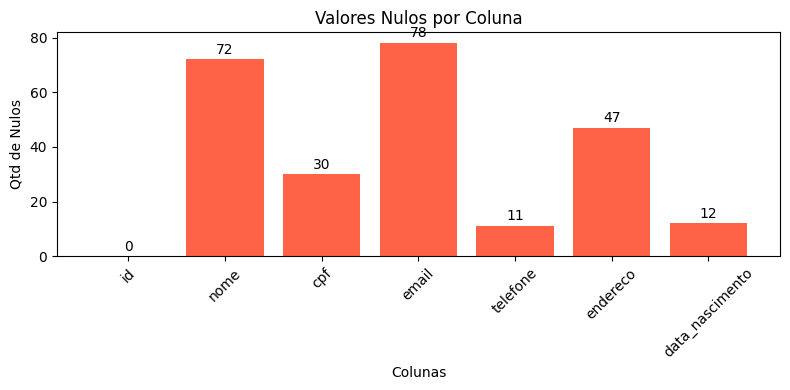

In [ ]:
# --------------------------
# 1) COMPLETUDE
# --------------------------
completude_report = validador.completude()

plt.figure(figsize=(8,4))
bars = plt.bar(completude_report["coluna"], completude_report["valores_nulos"], color="tomato")
plt.title("Valores Nulos por Coluna")
plt.xlabel("Colunas")
plt.ylabel("Qtd de Nulos")
plt.xticks(rotation=45)

for bar in bars:
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, altura + 1,  # posição
             str(int(altura)),  # valor
             ha='center', va='bottom')  # alinhamento

plt.tight_layout()
plt.show()

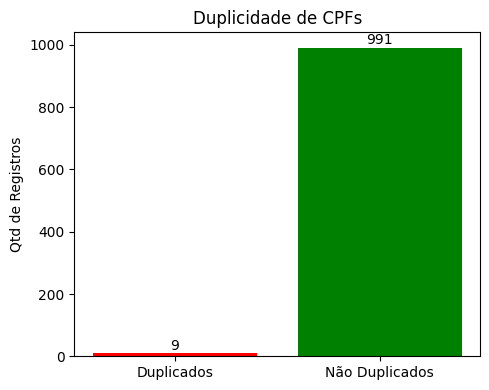

In [ ]:
# --------------------------
# 2) UNICIDADE (exemplo com CPF)
# --------------------------
unicidade_report = validador.unicidade(subset=["cpf"])

plt.figure(figsize=(5,4))
bars = plt.bar(
    ["Duplicados", "Não Duplicados"],
    [unicidade_report["duplicatas"], len(df) - unicidade_report["duplicatas"]],
    color=["red","green"]
)
plt.title("Duplicidade de CPFs")
plt.ylabel("Qtd de Registros")

for bar in bars:
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, altura + 1, str(int(altura)), ha='center', va='bottom')

plt.tight_layout()
plt.show()

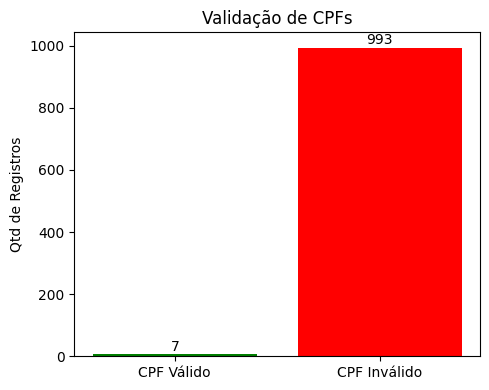

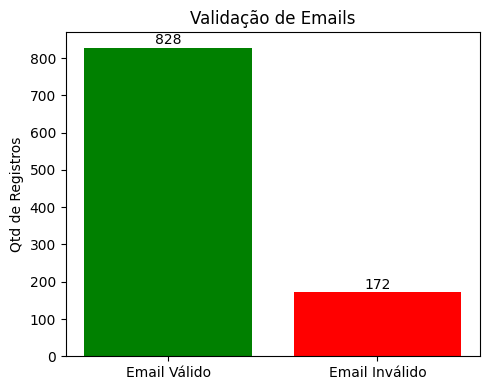

In [ ]:
# --------------------------
# 3) VALIDADE
# --------------------------
validade_report = validador.validade()

# CPF
cpf_valid = validade_report["CPF"]["Válidos"]
cpf_invalid = validade_report["CPF"]["Inválidos"]

plt.figure(figsize=(5,4))
bars = plt.bar(["CPF Válido", "CPF Inválido"], [cpf_valid, cpf_invalid], color=["green","red"])
plt.title("Validação de CPFs")
plt.ylabel("Qtd de Registros")

for bar in bars:
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, altura + 1, str(int(altura)), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Email
email_valid = validade_report["Email"]["Válidos"]
email_invalid = validade_report["Email"]["Inválidos"]

plt.figure(figsize=(5,4))
bars = plt.bar(["Email Válido", "Email Inválido"], [email_valid, email_invalid], color=["green","red"])
plt.title("Validação de Emails")
plt.ylabel("Qtd de Registros")

for bar in bars:
    altura = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, altura + 1, str(int(altura)), ha='center', va='bottom')

plt.tight_layout()
plt.show()